'/Users/user/Projects/AI/Memory-Episodic-Recall'

In [3]:
conda list | grep jupyter

jupyter                   1.1.1           py310hecd8cb5_0  
jupyter-lsp               2.2.5           py310hecd8cb5_0  
jupyter_client            8.6.3           py310hecd8cb5_0  
jupyter_console           6.6.3           py310hecd8cb5_0  
jupyter_core              5.7.2           py310hecd8cb5_0  
jupyter_events            0.12.0          py310hecd8cb5_0  
jupyter_server            2.15.0          py310hecd8cb5_0  
jupyter_server_terminals  0.5.3           py310hecd8cb5_0  
jupyterlab                4.3.4           py310hecd8cb5_0  
jupyterlab_pygments       0.3.0           py310hecd8cb5_0  
jupyterlab_server         2.27.3          py310hecd8cb5_0  
jupyterlab_widgets        3.0.13          py310hecd8cb5_0  

Note: you may need to restart the kernel to use updated packages.


In [34]:
# Re-import required libraries after kernel reset
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

In [35]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate multi-bit parity data (3-bit XOR: even=0, odd=1)
def generate_parity_data(bits=3):
    inputs = list(product([0, 1], repeat=bits))
    X = torch.tensor(inputs).float()
    Y = torch.tensor([sum(x) % 2 for x in inputs]).long()
    return X.to(device), Y.to(device)

In [40]:
# Episodic Memory with salience decay and timestamps
class EpisodicMemory:
    def __init__(self, dim, max_size=20, decay=0.01):
        self.memory = deque(maxlen=max_size)
        self.time = 0
        self.decay = decay
        self.usage_log = []
        self.recall_log = []

    def store(self, z, context, reward):
        self.time += 1
        if not self.memory or reward > np.median([m['r'] for m in self.memory]):
            self.memory.append({'z': z.detach(), 'c': context.detach(), 'r': reward, 't': self.time})

    def recall(self, z, top_k=2):
        if not self.memory:
            self.usage_log.append(0)
            self.recall_log.append([0])
            return torch.zeros_like(z)

        recalls = []
        scores = []
        for m in self.memory:
            age = self.time - m['t']
            sal = m['r'] * np.exp(-self.decay * age)
            sim = F.cosine_similarity(z.squeeze(), m['c'].squeeze(), dim=0).item()
            score = sim * sal
            scores.append(score)
            recalls.append((score, m['z']))
        self.usage_log.append(len(self.memory))
        self.recall_log.append(scores)
        top = sorted(recalls, key=lambda x: x[0], reverse=True)[:top_k]
        return torch.mean(torch.stack([v for _, v in top]), dim=0)


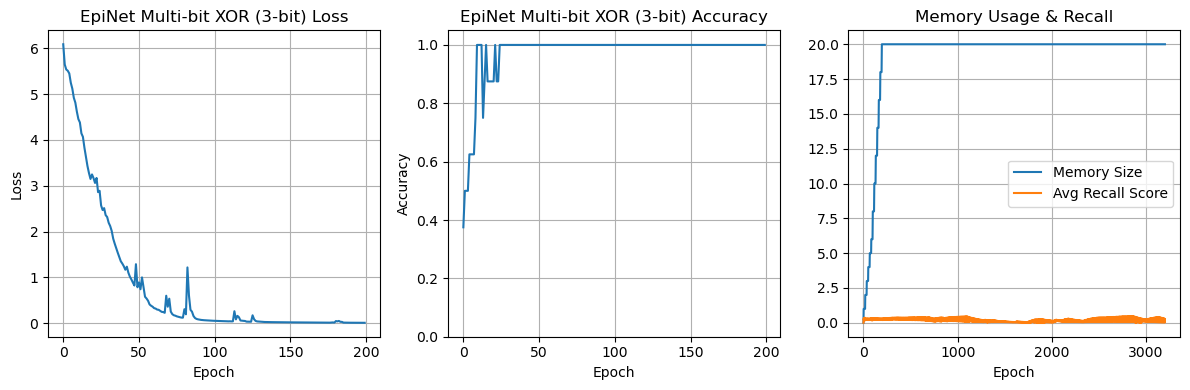

In [41]:
# EpiNet model for parity
class EpiNetParity(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 16), nn.ReLU())
        self.decoder = nn.Linear(32, 2)
        self.memory = EpisodicMemory(16)

    def forward(self, x):
        z = self.encoder(x)
        r_list = []
        for zi in z:
            ri = self.memory.recall(zi.unsqueeze(0))
            if ri.dim() == 1:
                ri = ri.unsqueeze(0)
            r_list.append(ri)
        r = torch.cat(r_list, dim=0)
        return self.decoder(torch.cat([z, r], dim=1)), z

# Load 3-bit parity data
X, Y = generate_parity_data(bits=3)

# Train EpiNet
model = EpiNetParity(input_dim=3).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.03)

losses = []
accuracies = []

for epoch in range(200):
    total_loss = 0
    for i in range(len(X)):
        x = X[i].unsqueeze(0)
        y = Y[i].unsqueeze(0)
        out, z = model(x)
        loss = F.cross_entropy(out, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        reward = 1.0 - loss.item()
        model.memory.store(z[0], z[0], reward)
        total_loss += loss.item()

    losses.append(total_loss)
    with torch.no_grad():
        out, _ = model(X)
        acc = (out.argmax(dim=1) == Y).float().mean().item()
        accuracies.append(acc)

# Plot Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title("EpiNet Multi-bit XOR (3-bit) Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(accuracies)
plt.title("EpiNet Multi-bit XOR (3-bit) Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(model.memory.usage_log, label="Memory Size")
if model.memory.recall_log:
    avg_recall = [np.mean(r) for r in model.memory.recall_log if r]
    plt.plot(avg_recall, label="Avg Recall Score")
plt.title("Memory Usage & Recall")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

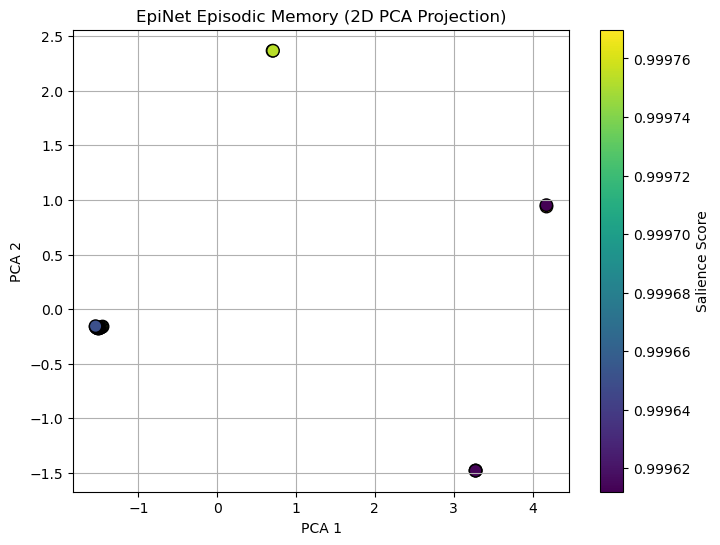

In [42]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Ensure memory is not empty
if not model.memory.memory:
    print("Memory is empty — no vectors to visualize.")
else:
    # Collect stored z vectors and salience
    stored_z = [m['z'].detach().cpu().numpy() for m in model.memory.memory]
    stored_salience = [m['r'] for m in model.memory.memory]

    stored_z = np.stack(stored_z)
    salience = np.array(stored_salience)

    # Reduce to 2D with PCA
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(stored_z)

    # Plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(reduced[:, 0], reduced[:, 1], c=salience, cmap='viridis', s=80, edgecolor='k')
    plt.title("EpiNet Episodic Memory (2D PCA Projection)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.colorbar(sc, label="Salience Score")
    plt.grid(True)
    plt.show()


In [46]:
import pandas as pd


# Step 1: Compute all metric arrays
accuracy_array = np.array(accuracies)
bwt_points = [50, 100, 150, 199]
bwt_scores = [accuracies[i] - accuracies[0] for i in bwt_points]

memory_usage = model.memory.usage_log
recall_scores = [np.mean(r) if isinstance(r, list) else 0 for r in model.memory.recall_log]

# Step 2: Truncate to the shortest length among the arrays to avoid DataFrame error
min_len = min(len(accuracy_array), len(memory_usage), len(recall_scores))

# Step 3: Build metrics DataFrame
import pandas as pd
metrics_df = pd.DataFrame({
    'Epoch': list(range(min_len)),
    'Accuracy': accuracy_array[:min_len],
    'MemoryUsage': memory_usage[:min_len],
    'RecallScore': recall_scores[:min_len]
})

# Display the metrics DataFrame
import ace_tools as tools; tools.display_dataframe_to_user(name="EpiNet Evaluation Metrics (Multi-bit XOR)", dataframe=metrics_df)

# Step 4: Plot the metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(metrics_df['Accuracy'], label="Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(metrics_df['MemoryUsage'], label="Memory Usage", color='orange')
plt.title("Memory Usage Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Stored Embeddings")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(metrics_df['RecallScore'], label="Avg Recall Score", color='green')
plt.title("Recall Score Trend")
plt.xlabel("Epoch")
plt.ylabel("Avg Recall Score")
plt.grid(True)

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'ace_tools'

In [45]:
print(len(accuracies), len(memory_usage), len(recall_scores))


200 3200 3200


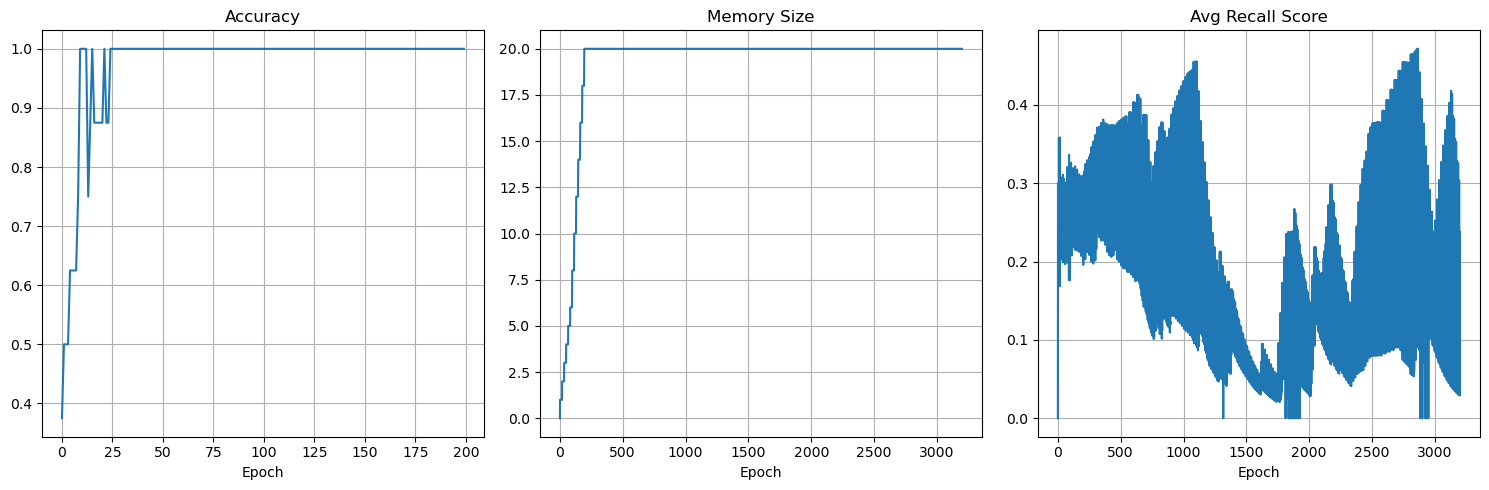

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(accuracies); plt.title("Accuracy"); plt.xlabel("Epoch"); plt.grid()

plt.subplot(1, 3, 2)
plt.plot(memory_usage); plt.title("Memory Size"); plt.xlabel("Epoch"); plt.grid()

plt.subplot(1, 3, 3)
plt.plot(recall_scores); plt.title("Avg Recall Score"); plt.xlabel("Epoch"); plt.grid()
plt.tight_layout(); plt.show()


Backward Transfer Evaluation (vs Epoch 0):
   Epoch  Accuracy  BWT vs Epoch 0
0      5     0.625           0.250
1     15     1.000           0.625
2     25     1.000           0.625
3     50     1.000           0.625
4    100     1.000           0.625
5    150     1.000           0.625
6    199     1.000           0.625


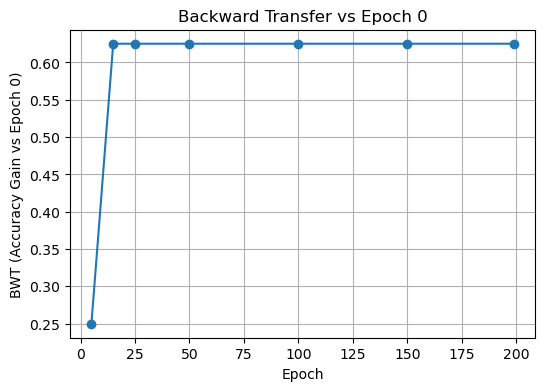

In [48]:
# BWT Estimation Points
bwt_checkpoints = [5, 15, 25, 50, 100, 150, 199]
acc_0 = accuracies[0]
bwt_scores = [accuracies[i] - acc_0 for i in bwt_checkpoints]

# Display BWT table
bwt_df = pd.DataFrame({
    "Epoch": bwt_checkpoints,
    "Accuracy": [accuracies[i] for i in bwt_checkpoints],
    "BWT vs Epoch 0": bwt_scores
})

print("Backward Transfer Evaluation (vs Epoch 0):")
print(bwt_df)

# Optional: plot BWT trend
plt.figure(figsize=(6, 4))
plt.plot(bwt_checkpoints, bwt_scores, marker='o')
plt.title("Backward Transfer vs Epoch 0")
plt.xlabel("Epoch")
plt.ylabel("BWT (Accuracy Gain vs Epoch 0)")
plt.grid(True)
plt.show()
